In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import numpy as np
import os

In [12]:
# Data loading
path = r'../data/interim/data_v1.csv'
alzheimer_v1_df = pd.read_csv(path)

## Study of inconsistencies

In [13]:
# Step 0: Create a working copy for consistency checks
alzheimer_check_df = alzheimer_v1_df.copy()

# Step 1: Calculate cumulative sum of H and M
alzheimer_check_df['Suma_HM_actual'] = alzheimer_check_df['H'] + alzheimer_check_df['M']
alzheimer_check_df['Suma_HM_anterior'] = alzheimer_check_df.groupby('Entidad')['Suma_HM_actual'].shift(1)

# Step 2: Compute the difference
alzheimer_check_df['Diferencia_calculada'] = (
    alzheimer_check_df['Suma_HM_actual'] - alzheimer_check_df['Suma_HM_anterior']
)

# Step 3: Create a flag for week 2 (reset of cumulative values)
alzheimer_check_df['Es_reinicio'] = alzheimer_check_df['Semana'] == 2

# Step 4: For week 2, the expected difference equals the current cumulative sum
alzheimer_check_df.loc[
    alzheimer_check_df['Es_reinicio'], 'Diferencia_calculada'
] = alzheimer_check_df['Suma_HM_actual']

# Step 5: Verify consistency with a small tolerance
alzheimer_check_df['Coherente'] = (
    abs(alzheimer_check_df['Diferencia_calculada'] - alzheimer_check_df['Sem.']) < 0.001
)

# Step 6: Filter inconsistencies (excluding the first week of each entity)
alzheimer_inconsistencias_df = alzheimer_check_df[
    ~alzheimer_check_df['Coherente'] &
    alzheimer_check_df['Suma_HM_anterior'].notna()
].copy()

# Step 7: Keep only relevant columns
columns_to_keep = ['Entidad', 'Año', 'Semana', 'Año_Epi', 'Sem.', 'H', 'M', 'Diferencia_calculada']
alzheimer_inconsistencias_df = alzheimer_inconsistencias_df[columns_to_keep]

# Step 8: Summary
total_checked = alzheimer_check_df['Suma_HM_anterior'].notna().sum()
total_inconsistent = len(alzheimer_inconsistencias_df)

print(f"Total records checked: {total_checked}")
print(f"Inconsistencies found: {total_inconsistent}")

Total records checked: 18272
Inconsistencies found: 695


In [14]:
alzheimer_inconsistencias_df.head(10)

,Entidad,Año,Semana,Año_Epi,Sem.,H,M,Diferencia_calculada
42,Aguascalientes,2014,44,2014,0.0,2.0,4.0,1.0
82,Aguascalientes,2015,31,2015,0.0,2.0,7.0,1.0
95,Aguascalientes,2015,44,2015,0.0,3.0,9.0,-1.0
112,Aguascalientes,2016,9,2016,0.0,1.0,5.0,2.0
119,Aguascalientes,2016,16,2016,0.0,4.0,8.0,2.0
122,Aguascalientes,2016,19,2016,0.0,5.0,9.0,1.0
123,Aguascalientes,2016,20,2016,1.0,17.0,18.0,21.0
124,Aguascalientes,2016,21,2016,0.0,5.0,9.0,-21.0
125,Aguascalientes,2016,22,2016,2.0,6.0,11.0,3.0
136,Aguascalientes,2016,33,2016,1.0,13.0,21.0,3.0


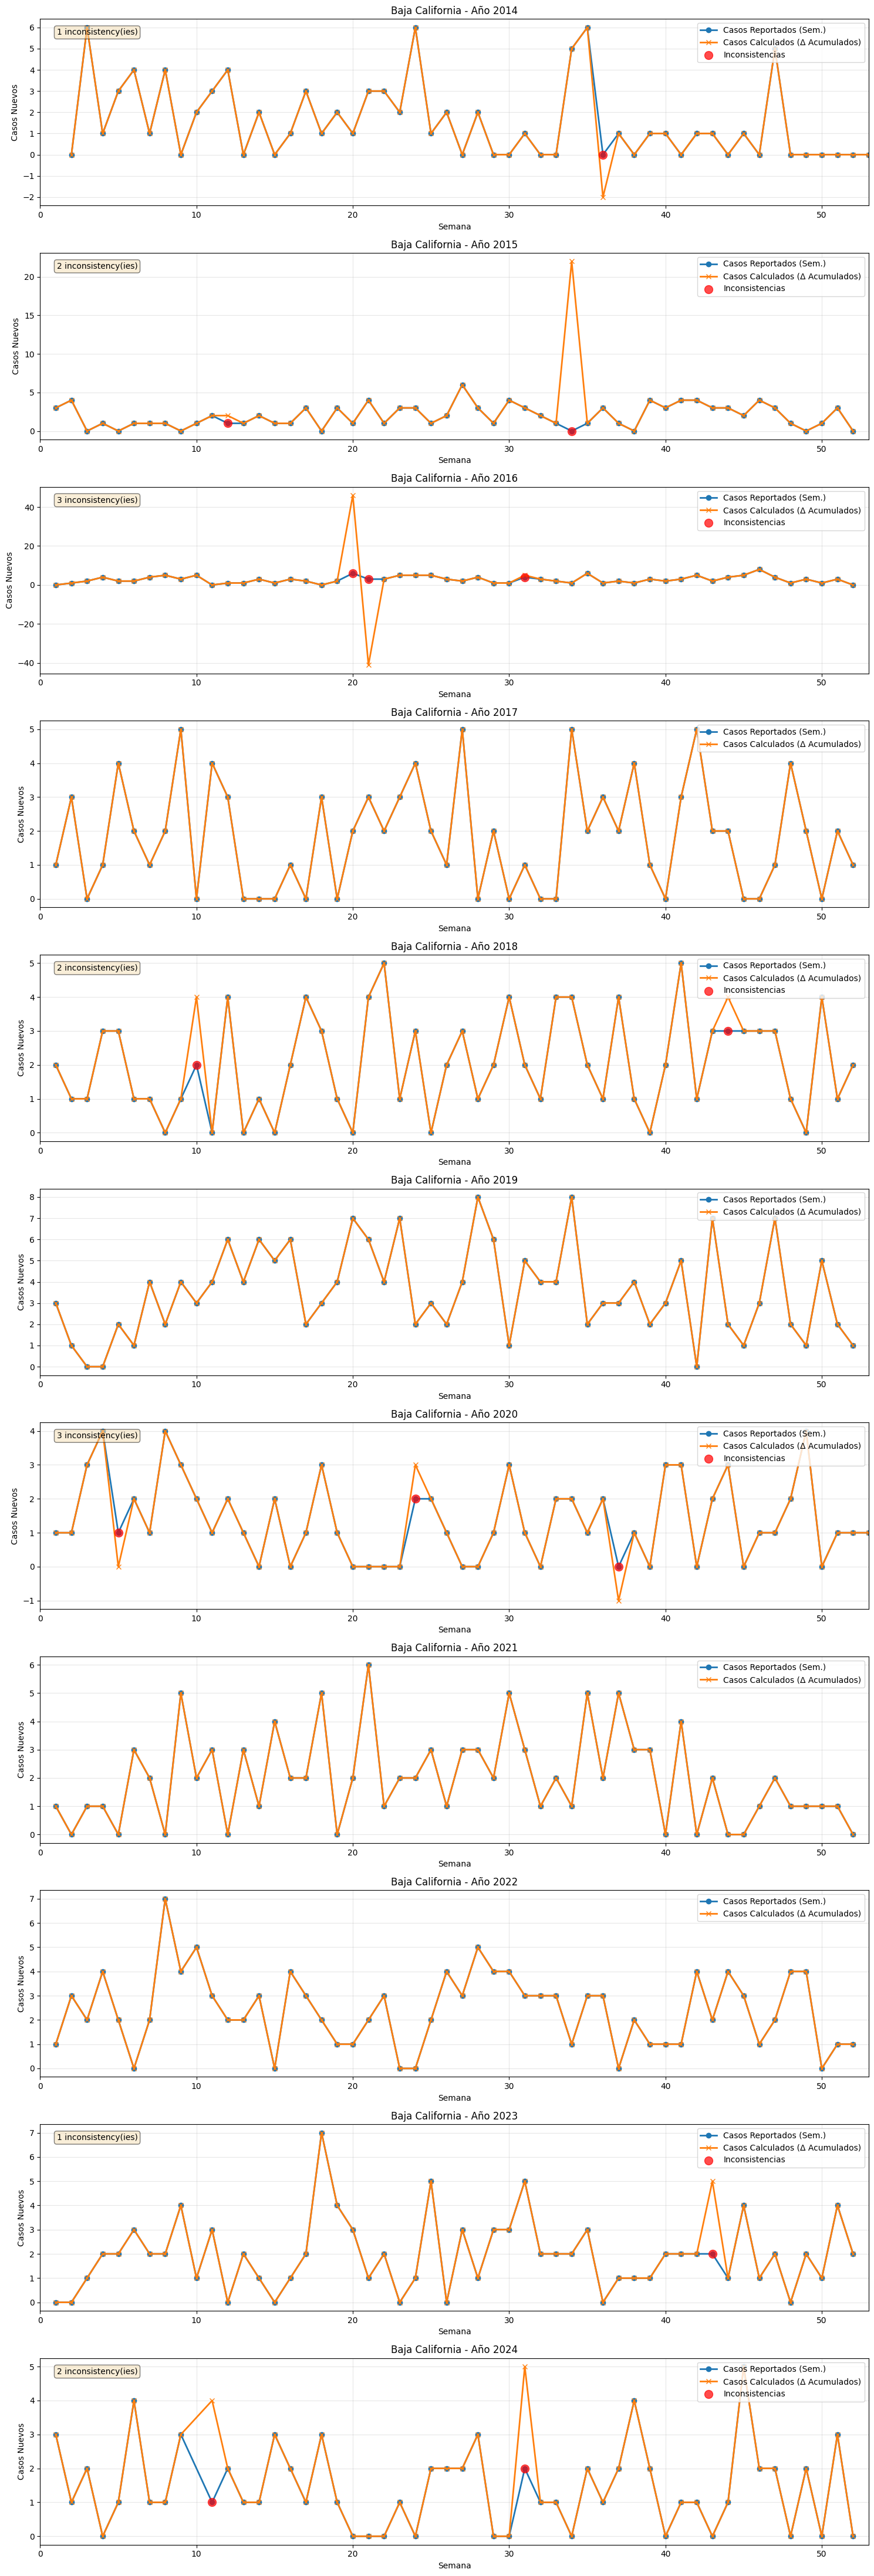

In [15]:
# Step 8: Plot comparison per entity and year
entidad = 'Baja California'  # change as needed
df_entidad = alzheimer_check_df[alzheimer_check_df['Entidad'] == entidad].copy()
years = sorted(df_entidad['Año'].unique())
n_years = len(years)

fig, axes = plt.subplots(n_years, 1, figsize=(15, 4 * n_years))
if n_years == 1:
    axes = [axes]

for idx, year in enumerate(years):
    df_year = df_entidad[df_entidad['Año'] == year].copy()
    ax = axes[idx]

    # Plot both lines: reported vs calculated
    ax.plot(df_year['Semana'], df_year['Sem.'], label='Casos Reportados (Sem.)', marker='o', linewidth=2)
    ax.plot(df_year['Semana'], df_year['Diferencia_calculada'], label='Casos Calculados (Δ Acumulados)', marker='x', linewidth=2)

    # Highlight inconsistencies
    differences = abs(df_year['Sem.'] - df_year['Diferencia_calculada']) > 0.001
    if differences.any():
        ax.scatter(df_year.loc[differences, 'Semana'], df_year.loc[differences, 'Sem.'],
                   color='red', s=100, zorder=5, label='Inconsistencias', alpha=0.7)
        n_incon = differences.sum()
        ax.text(0.02, 0.95, f'{n_incon} inconsistency(ies)',
                transform=ax.transAxes, fontsize=10,
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    # Aesthetics
    ax.set_xlabel('Semana')
    ax.set_ylabel('Casos Nuevos')
    ax.set_title(f'{entidad} - Año {year}')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, 53)

plt.tight_layout()
plt.show()


In [16]:
output_folder = '../data/interim/'
filename = 'data_inconsistencies.csv'
route = os.path.join(output_folder, filename)


alzheimer_inconsistencias_df.to_csv(
    route,
    index=False,
    encoding='utf-8'
)

In [17]:
alzheimer_inconsistencias_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 695 entries, 42 to 17856
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Entidad               695 non-null    object 
 1   Año                   695 non-null    int64  
 2   Semana                695 non-null    int64  
 3   Año_Epi               695 non-null    int64  
 4   Sem.                  695 non-null    float64
 5   H                     695 non-null    float64
 6   M                     695 non-null    float64
 7   Diferencia_calculada  695 non-null    float64
dtypes: float64(4), int64(3), object(1)
memory usage: 48.9+ KB
